In [1]:
import numpy as np
import pip
import torch
from torch import nn
import argparse
from torch.autograd import Variable
import io
from scipy import linalg
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
def load_pretrained_embeddings(path):

    word2id = {}
    vectors = []
    id2word={}
    emb_path =path
    _emb_dim_file = 300
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n') as f:
        for i, line in enumerate(f):
            if i!=0:
                word, vect = line.rstrip().split(' ', 1)
                
                word = word.lower()
                vect = np.fromstring(vect, sep=' ')
                             
                word2id[word] = len(word2id)
                id2word[len(word2id)]=word
                vectors.append(vect[None])
            if len(word2id) >= 200000:
                break

    
    print("Done")
    embeddings = np.concatenate(vectors, 0)
    embeddings = torch.from_numpy(embeddings).float()
       
    return embeddings,word2id,id2word


In [3]:
src_embedding,src_word2id,src_id2word=load_pretrained_embeddings("../MUSE/data/wiki.en.vec")
tgt_embedding,tgt_word2id,tgt_id2word=load_pretrained_embeddings("../MUSE/data/wiki.es.vec")

Done
Done


In [4]:
src_embeddings = nn.Embedding(200000, 300, sparse=True)
src_embeddings.weight.data.copy_(src_embedding)

tgt_embeddings = nn.Embedding(200000, 300, sparse=True)
tgt_embeddings.weight.data.copy_(tgt_embedding)

src_embeddings.cuda()
tgt_embeddings.cuda()

Embedding(200000, 300, sparse=True)

In [70]:

def get_batch2(X,batch_size):
 

    N=200000
    batch_indices = torch.LongTensor( np.random.randint(0,N,size=batch_size) )

    batch_xs = X(Variable(batch_indices).cuda())

    return batch_xs.cuda()

In [71]:
class Discriminator(nn.Module):

    def __init__(self, dis_hid_dim,dis_input_dropout):
        super(Discriminator, self).__init__()

        self.emb_dim = 300
        self.dis_layers = 2
        self.hidden_dim = dis_hid_dim
        self.dis_input_dropout = dis_input_dropout
        
        self.layers=nn.Sequential(nn.Dropout(self.dis_input_dropout),nn.Linear(self.emb_dim, self.hidden_dim),nn.LeakyReLU(0.2),nn.Linear(self.hidden_dim, self.hidden_dim),nn.LeakyReLU(0.2),nn.Linear(self.hidden_dim, 1),nn.Sigmoid())

        

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == self.emb_dim
        return self.layers(x).view(-1)

In [72]:
mapping = nn.Linear(300, 300, bias=False)
mapping.weight.data.copy_(torch.eye(300))
modelDisc= Discriminator(2048,0.1)

def Orthogonal(mapping,beta):
    W=mapping.weight.data
    mapping.weight.data.copy_((1 + beta) * W - beta * W.mm(W.transpose(0, 1).mm(W)))
    return mapping


In [73]:
mapping.cuda()
modelDisc.cuda()
linoptimizer = torch.optim.SGD(mapping.parameters(), lr=0.1)
discoptimizer= torch.optim.SGD(modelDisc.parameters(), lr=0.1)

loss_fn=torch.nn.BCELoss()

In [74]:
def get_xy():
#get minibatch of spanish words
    tgt_batch=get_batch2(tgt_embeddings,batch_size)
    #getminibatch of english words
    src_batch=get_batch2(src_embeddings,batch_size)

    #generate fake spanish embeddings
    fake_tgt_batch= mapping(src_batch)

    #stack real and fake
    x = torch.cat([fake_tgt_batch, tgt_batch], 0)
    #         print(x.shape)
    y = torch.FloatTensor(2 * batch_size).zero_()
    
    y[batch_size:] = 0.2
    y[:batch_size]=1-0.2
    y=Variable(y).cuda()
    return x,y

In [75]:
def get_csls(src_emb, tgt_emb, knn=10):
 
    bs = 1024
    all_distances = []
    emb=tgt_emb.transpose(0,1)
    for i in range(0, src_emb.shape[0], bs):
        distances = src_emb[i:i + bs].mm(emb)
        best_distances, _ = distances.topk(knn, dim=1, largest=True, sorted=True)
        all_distances.append(best_distances.mean(1).cpu())
    all_distances = torch.cat(all_distances)
    return all_distances.numpy()


def get_neighbour(src_emb,tgt_emb):
    bs = 128

    all_sc = []
    all_tgt = []

    n_src =30000
    knn = 10

 
    avg_dis1 = torch.from_numpy(get_csls(src_emb, tgt_emb, knn)).type_as(src_emb)
    avg_dis2 = torch.from_numpy(get_csls(tgt_emb, src_emb, knn)).type_as(tgt_emb)


    for i in range(0, n_src, bs):
        
        scores = tgt_emb.mm(src_emb[i:min(n_src, i + bs)].transpose(0, 1)).transpose(0, 1)
        scores.mul_(2)
        scores.sub_(avg_dis1[i:min(n_src, i + bs)][:, None] + avg_dis2[None, :])
        best_scores, best_tgt = scores.topk(2, dim=1, largest=True, sorted=True)

     
        all_sc.append(best_scores.cpu())
        all_tgt.append(best_tgt.cpu())

    all_sc = torch.cat(all_sc, 0)
    all_tgt = torch.cat(all_tgt, 0)

    all_pairs = torch.cat([torch.arange(0, all_tgt.size(0)).long().unsqueeze(1),all_tgt[:, 0].unsqueeze(1)], 1)


    diff = all_sc[:, 0] - all_sc[:, 1]
    reordered = diff.sort(0, descending=True)[1]
    all_sc = all_sc[reordered]
    all_pairs = all_pairs[reordered]
    
    
    selected = all_pairs.max(1)[0] <= 30000
    mask = selected.unsqueeze(1).expand_as(all_sc).clone()
    all_sc = all_sc.masked_select(mask).view(-1, 2)
    all_pairs = all_pairs.masked_select(mask).view(-1, 2)
    return all_pairs


def create_dictionary(src_embedding,tgt_embedding):
    src2tgt = get_neighbour(src_embedding,tgt_embedding)
    tgt2src = get_neighbour(tgt_embedding,src_embedding)
    
    tgt2src = torch.cat([tgt2src[:, 1:], tgt2src[:, :1]], 1)
    
    final_pairs = set([(a, b) for a, b in src2tgt]) & set([(a, b) for a, b in tgt2src])
    dictionary = torch.LongTensor(list([[a, b] for (a, b) in final_pairs]))

    print('Dictionary Length = %i.' % dictionary.size(0))
    return dictionary.cuda()

def evaluation_metric(src_embs, tgt_embs):
     
    indices= torch.LongTensor(np.arange(200000))
    batch_xs = src_embs(Variable(indices).cuda())
    src_emb = mapping(batch_xs.cuda())
    src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
    tgt_emb = tgt_embs(Variable(indices).cuda())
    tgt_emb=torch.FloatTensor(tgt_emb.cpu().data.numpy()).cuda()
    src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
    tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)
    dictionary = create_dictionary(src_emb, tgt_emb)
    mean_cosine = (src_emb[dictionary[:, 0]] * tgt_emb[dictionary[:, 1]]).sum(1).mean()
    print("Mean cosine", mean_cosine)
    return mean_cosine

In [76]:
iterations_per_epoch=1000000
batch_size=32
epoch=5
val_score=-1

for _ in range(epoch):
      
    for _n in range(0,iterations_per_epoch,batch_size):
        modelDisc.train()
        mapping.eval()
        for __ in range(5):

            x,y=get_xy()
            
            y_pred = modelDisc(Variable(x.data))

            loss= loss_fn(y_pred, y)

            discoptimizer.zero_grad()


            loss.backward()
    #         print(loss.data)
  
            discoptimizer.step()
          
        modelDisc.eval()
        mapping.train()
        for __ in range(1):
            
            x,y=get_xy()
            
            y=1-y
            y_pred = modelDisc(x)
            loss2= loss_fn(y_pred, y)
            linoptimizer.zero_grad()
            loss2.backward()
            linoptimizer.step()

            mapping=Orthogonal(mapping,0.001)
        if _n%500==0:
            print(torch.norm(mapping.weight.data,2))
            print(_n," Discriminator Loss :  ",loss.data)
            print("Generator Loss : ", loss2.data)
        
    val=evaluation_metric(src_embeddings,tgt_embeddings)
    if val_score<val:
        torch.save(mapping.state_dict(), './mapping.pth')
        val_score=val
    

    
    

17.3204421997
(0, ' Discriminator Loss :  ', 
 0.6786
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.7156
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)


KeyboardInterrupt: 

In [77]:
def build_dictionary(src_emb,tgt_emb):
    src_emb = mapping(Variable(src_emb, requires_grad=False).cuda())
    src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
    tgt_emb = tgt_emb.cuda()
    src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
    tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)
    dictionary= create_dictionary(src_emb, tgt_emb)
    return dictionary

dictionary=build_dictionary(src_embedding,tgt_embedding)

    

Dictionary Length = 1193.


In [13]:
def procrustes(src_emb,tgt_emb):
    A = src_emb.weight.data[list(dictionary[:, 0])]
    B = tgt_emb.weight.data[list(dictionary[:, 1])]
    M = B.transpose(0, 1).mm(A).cpu().numpy()
    U, S, V_t = linalg.svd(M, full_matrices=True)
    mapping.weight.data.copy_(torch.from_numpy(U.dot(V_t)).type_as(mapping.weight.data))


In [14]:
procrustes(src_embeddings,tgt_embeddings)
val=evaluation_metric(src_embeddings,tgt_embeddings)
if val_score<val:
    torch.save(mapping.state_dict(), './mapping.pth')


KeyboardInterrupt: 

In [78]:
# fake_src_embeddings=(mapping(Variable(src_embedding, requires_grad=False).cuda())).cuda()
# fake_src_embeddings=torch.FloatTensor(fake_src_embeddings.cpu().data.numpy())
pca = PCA(n_components=2, whiten=True)  
#pca.fit(np.vstack([fake_src_embeddings, tgt_embedding]))
pca.fit(tgt_embedding)


print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())


Variance explained: 0.08


In [79]:

def plot_embedding_space(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    

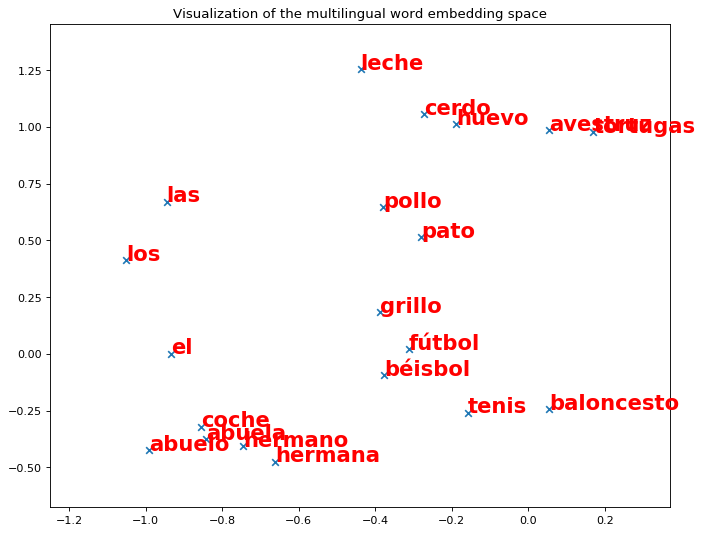

In [114]:
src_words = []
tgt_words = ['leche','el','los','las', 'pato','pollo','avestruz','tortugas','cerdo','abuelo','abuela','hermana','hermano','huevo', u'tenis',u'fútbol','baloncesto',u'béisbol','grillo','']
plot_embedding_space(src_words,src_word2id,src_embedding.cpu().numpy(),tgt_words,tgt_word2id,tgt_embedding.cpu().numpy(),pca)


In [81]:
pca2 = PCA(n_components=2, whiten=True)  
#pca.fit(np.vstack([fake_src_embeddings, tgt_embedding]))
pca2.fit(src_embedding)


print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())


Variance explained: 0.08


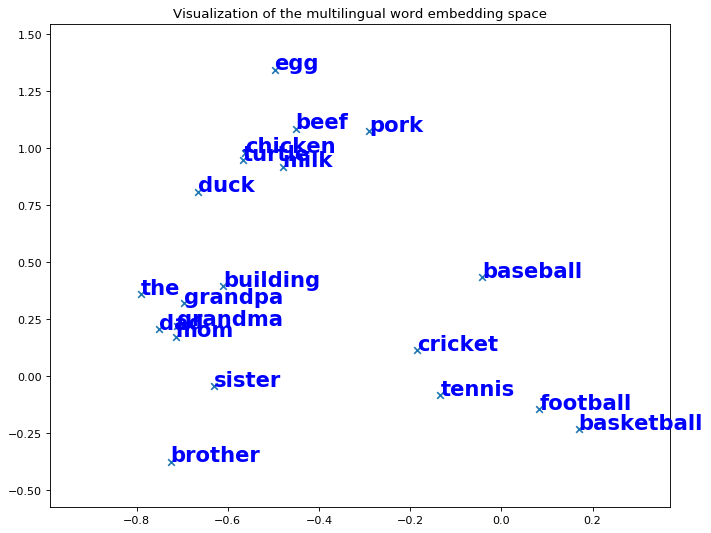

In [115]:
src_words = ['the','chicken','duck','turtle','beef','pork','egg','mom','dad','grandpa','grandma','sister','brother','milk','tennis','football','basketball','cricket','baseball','']
tgt_words = []
plot_embedding_space(src_words,src_word2id,src_embedding.cpu().numpy(),tgt_words,tgt_word2id,tgt_embedding.cpu().numpy(),pca2)